# Sequential Monte Carlo
When we have data coming in a form of sequence, we try to evaluate the next T steps of the data. This help us see the future across multiple paths created using the samplers.

Now there are 2 types of models in Sequential structure. In one kind we worry about each of the intermediate marginal distribution and the other we care about only the final distribution. The 1st kind is called particle filtering. We are going to talk about particle filtering here.


# SIS, SISR & SISR with Adaptive resampling

Sequential importance sampling (SIS) is one of the techniques to generate samples and give preferences to weights by normalizing it in particle filtering. Here we consider the proposal distribution to have a from of,
$$
q_t(z_{1:t}) = q_{t-1}(z_{1:t-1})q_t(z_t|z_{1:t-1})
$$
$$
\tilde w_t(z_{1:t}) = \dfrac{\tilde\gamma_t(z_{1:t})}{q_t(z_{1:t})} = \tilde w_{t-1}(z_{1:t-1})\dfrac{\tilde\gamma_t(z_{1:t})}{\tilde\gamma_{t-1}(z_{1:t-1})q_t(z_t|z_{1:t-1})}
$$
So the 2nd term is called alpha/incremental weight,
$$
\alpha_t(z_{1:t}) = \dfrac{\tilde\gamma_t(z_{1:t})}{\tilde\gamma_{t-1}(z_{1:t-1})q_t(z_t|z_{1:t-1})} = \dfrac{p(y_t|z_{1:t})p(z_t|z_{1:t-1})}{q_t(z_t|z_{1:t-1})}
$$
Here I have used Sequence importance sampling method to showcase how the values change state as the sequence move forward. However this suffers from a weight degeneracy problem where the normalized weights become near to zero. 

So solve this we modify the algorithm by resampling the latent variables at every step. This is called Sequential importance sampling with resampling (SISR). This solves the weight degeneracy problem to certain extend but this introduces another problem called path degeneracy problem, where it moves less along the path. You can see the effect of it in the 2d-tracking problem I discuss below.

So to solve theses problems an SISR with Adaptive logic was introduced which is also called generic SMC (Sequential Monte Carlo). Which resamples only when the weights are less than some minimum weight. In the below 2d-tracking problem we have adjusted the minimum weight to around 25% of the total steps.

For this example we take a gaussian model with latent defined by
$$
p(z_t|z_{1:t-1}) = N(z_t|\phi z_{t-1},q)
$$
and the output sequence dependent on latent is given by
$$
p(y_t|z_{1:t}) = N(y_t|\sum_{s=1}^t \beta^{t-s}z_s,r)
$$
So for coding purpose if we break the above equation and use the pre-calculated $\mu$ then the break-down for $t=5$ becomes,
$$\mu_{current} = \beta^4z_1 + \beta^3z_2 + \beta^2z_3 + \beta z_4 + z_5 $$
$$\mu_{next} = \beta^5z_1 + \beta^4z_2 + \beta^3z_3 + \beta^2 z_4 + \beta z_5 + z_6 $$ 
$$\mu_{next} = \beta(\beta^4z_1 + \beta^3z_2 + \beta^2z_3 + \beta z_4 + z_5) + z_6 $$ 
$$\mu_{next} = \beta(\mu_{current}) + z_6 $$ 
So, our equation becomes,
$$
\mu_{t} = \beta(\mu_{t-1}) + z_t \\
$$


In [237]:
from typing import Callable, List, NamedTuple
import torch
import matplotlib.pyplot as plt

class Constants(NamedTuple):
    phi: torch.Tensor = torch.tensor([0.9])
    q: torch.Tensor = torch.tensor([10.0])
    beta: torch.Tensor = torch.tensor([0.5])
    r: torch.Tensor = torch.tensor([1.0])

init_constants = Constants()

class GaussianSequenceModel:

    def __init__(self, init_constants: Constants, N_s):
        self.init_constants = init_constants
        self.N_s = N_s

    def sample_z_step(self, prev_zt):
        phi = self.init_constants.phi
        q = self.init_constants.q
        zt = torch.distributions.Normal(loc=phi*prev_zt, scale=torch.sqrt(q)).sample()
        return zt

    def y_step(self, prev_y_mu_t, zt):
        beta = self.init_constants.beta
        r = self.init_constants.r
        mu_t = torch.vmap(lambda mu_i,z_i_t : beta*mu_i+z_i_t)(prev_y_mu_t,zt)
        y_t_dist = torch.distributions.Normal(loc=mu_t.ravel(), scale=torch.sqrt(r))
        return mu_t, y_t_dist

    def sample_y_step(self, prev_y_mu_t, zt):
        mu_t, y_t_dist = self.y_step(prev_y_mu_t, zt)
        y_t = y_t_dist.sample()
        return mu_t.ravel(), y_t.ravel(), y_t_dist
    
    def sample_step(self, prev_zt, prev_y_mu_t):
        zt = self.sample_z_step(prev_zt)
        mu_t, y_t, _ = self.sample_y_step(prev_y_mu_t,zt)

        return (zt, mu_t), torch.cat((zt.unsqueeze(0), y_t.unsqueeze(0)))
    
    def sample(self, nsteps):
        mu_0, z_i_0, _ = self.inits(self.N_s)
        init_values = (mu_0,z_i_0)
        def scan(func, init_values, length):
            carry = init_values
            logs_chain = []
            for i in range(length):
                carry, logs = func(carry[0], carry[1])
                logs_chain.append(logs)
            logs_output = torch.stack(logs_chain,dim=1)
            return carry, logs_output
        _, logs_chain = scan(self.sample_step, init_values, nsteps)
        return logs_chain

    def inits(self, N_s):
        mu_0 = torch.zeros(N_s)
        z_i_0 = torch.zeros(N_s)
        w_i_0 = torch.zeros(N_s)
        return mu_0, z_i_0, w_i_0
    
    def sis(self, y_ts, T):
        z_1 = torch.tensor([0])
        z_i_t = self.sample_z_step(z_1.repeat((self.N_s)))
        w_i_t = y_ts[0]/z_i_t
        W_i_t = w_i_t/w_i_t.sum()
        mc_post_t = (W_i_t*torch.abs(z_1-z_i_t)).sum()
        normalized_w, posteriors = [],[]
        posteriors.append(mc_post_t)
        normalized_w.append(W_i_t)
        for t in range(1,T):
            z_i_t = self.sample_z_step(z_i_t) 
            alpha = y_ts[t]/(y_ts[t-1]*z_i_t)
            w_i_t = w_i_t*alpha
            W_i_t = torch.nn.functional.normalize(w_i_t, dim=-1)
            normalized_w.append(W_i_t)
            mc_post_t = (W_i_t*torch.abs(z_i_t.mean()-z_i_t)).sum()
            posteriors.append(mc_post_t)
        return torch.stack(posteriors), torch.stack(normalized_w)

    def resample_permute(self, w_i_t, z_i_t):
        indexs = torch.distributions.Categorical(logits=w_i_t).sample((self.N_s,))
        z_i_t = torch.stack([z_i_t[i] for i in indexs])
        w_i_t = 1/self.N_s * torch.ones((self.N_s))
        return indexs, z_i_t, w_i_t
    
    def sisr(self, y_ts, T):
        z_1 = torch.tensor([0])
        z_i_t = self.sample_z_step(z_1.repeat((self.N_s)))
        w_i_t = y_ts[0]/z_i_t
        W_i_t = w_i_t/w_i_t.sum()
        mc_post_t = (W_i_t*torch.abs(z_1-z_i_t)).sum()
        normalized_w, selected_indexs, posteriors = [], [], []
        normalized_w.append(W_i_t)
        posteriors.append(mc_post_t)
        for t in range(1,T):
            indexes, z_i_t, w_i_t = self.resample_permute(w_i_t, z_i_t)
            selected_indexs.append(indexes)
            z_i_t = self.sample_z_step(z_i_t)
            w_i_t = y_ts[t]/(y_ts[t-1] * z_i_t)
            W_i_t = torch.nn.functional.normalize(w_i_t, dim=-1)
            mc_post_t = (W_i_t*torch.abs(z_i_t.mean()-z_i_t)).sum()
            normalized_w.append(W_i_t)
            posteriors.append(mc_post_t)
        return torch.stack(posteriors), torch.stack(normalized_w), torch.stack(selected_indexs)
        
    def sisr_with_adaptive_resampling(self, y_ts, T, min_weight):
        z_1 = torch.tensor([0])
        z_i_t = self.sample_z_step(z_1.repeat((self.N_s)))
        w_i_t = y_ts[0]/z_i_t
        W_i_t = w_i_t/w_i_t.sum()
        mc_post_t = (W_i_t*torch.abs(z_1-z_i_t)).sum()
        normalized_w, Z_ts, posteriors, selected_indexs = [], [], [], []
        prev_w_i_t = torch.ones(self.N_s)
        Z_t = 1
        normalized_w.append(W_i_t)
        posteriors.append(mc_post_t)

        for t in range(1, T):
            z_i_t = self.sample_z_step(z_i_t)
            alpha = y_ts[t]/(y_ts[t-1]*z_i_t)
            w_i_t = w_i_t*alpha
            # # normalization const
            Z_ts.append(self.calc_Z(w_i_t, prev_w_i_t, Z_t))
            if self.ESS(w_i_t, ess_min=min_weight):
                indexes, z_i_t, w_i_t = self.resample_permute(w_i_t, z_i_t)
                selected_indexs.append((t, indexes))
            W_i_t = torch.nn.functional.normalize(w_i_t, dim=-1)
            mc_post_t = (W_i_t*torch.abs(z_i_t.mean()-z_i_t)).sum()
            normalized_w.append(W_i_t)
            posteriors.append(mc_post_t)
        return torch.stack(posteriors), torch.stack(normalized_w), torch.stack(Z_ts), selected_indexs

    def ESS(self, w_i_t, ess_min):
        ess = w_i_t.sum().square() / w_i_t.square().sum()
        if ess < ess_min:
            return True
        else:
            return False
        
    def calc_Z(self, w_i_t, prev_w_i_t, prev_Z_t):
        # Z_t/Z_{t-1}
        Z_t_Z_t_1 = w_i_t.sum() / prev_w_i_t.sum()
        # Z_t
        return prev_Z_t * Z_t_Z_t_1
    
particles = 5
T = 10
model = GaussianSequenceModel(init_constants, N_s=particles)
samples = model.sample(T)
print('sample (zts, yts) shape', samples.shape)
y_ts = torch.squeeze(samples.split(1)[-1])
print('only yts shape : ',y_ts.shape)
# SIS
p_sis, w_sis = model.sis(y_ts, T)
# SISR
p_smc, w_smc, s_idxs = model.sisr(y_ts, T)
# SISR_Adaptive
p_g_sisr_ad, w_g_sisr_ad, nc_g_sisr_ad , s_idxs_sisr_ad = model.sisr_with_adaptive_resampling(y_ts, T, min_weight=particles/5)
# print(f'Normalized weights for sequential_importance_sampling : \n {weights_sis}')
print(f'Normalized weights for sequential_importance_resampling : \n {w_smc}')
print(f'Normalized weights for sequential_importance_resampling_adaptive : \n {w_g_sisr_ad}')

sample (zts, yts) shape torch.Size([2, 10, 5])
only yts shape :  torch.Size([10, 5])
Normalized weights for sequential_importance_resampling : 
 tensor([[-6.6174e-01,  6.6187e-02, -9.7740e-02, -4.4313e-01,  2.1364e+00],
        [-1.8866e-01,  8.9358e-01,  3.5519e-01,  7.0895e-02,  1.8638e-01],
        [-8.6953e-02, -3.1492e-04, -2.4521e-01,  9.1163e-01, -3.1818e-01],
        [-4.1938e-02,  9.9866e-01, -1.2471e-02, -2.3220e-02, -1.5050e-02],
        [-1.6795e-02, -5.5831e-02, -1.2844e-03, -3.8192e-02,  9.9757e-01],
        [ 4.9757e-01, -4.2751e-01, -7.5116e-01,  2.7587e-02, -6.8301e-02],
        [ 4.9504e-02, -9.9616e-01, -5.9280e-02,  3.9084e-02,  1.3173e-02],
        [-3.2842e-02, -1.6739e-01,  1.7384e-01,  9.2731e-01,  2.8420e-01],
        [-9.8761e-01,  1.2042e-01,  7.7607e-02,  2.1090e-02, -6.0432e-02],
        [ 5.8333e-01,  5.7038e-01, -2.4771e-01, -1.4537e-01, -5.0191e-01]])
Normalized weights for sequential_importance_resampling_adaptive : 
 tensor([[ 1.4396e+00, -1.6778e-02, 

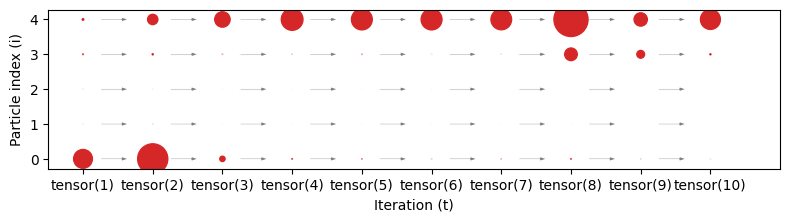

In [238]:
def plot_sis_weights(weights, n_steps, spacing=1.5, max_size=0.3):
    """
    Plot the evolution of weights in the sequential importance sampling (SIS) algorithm.

    Parameters
    ----------
    weights: array(n_particles, n_steps)
        Weights at each time step.
    n_steps: int
        Number of steps to plot.
    spacing: float
        Spacing between particles.
    max_size: float
        Maximum size of the particles.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect(1)
    weights_subset = weights[:n_steps]
    for col, weights_row in enumerate(weights_subset):
        norm_cst = weights_row.sum()
        radii = weights_row / norm_cst * max_size
        for row, rad in enumerate(radii):
            if col != n_steps - 1:
                plt.arrow(spacing * (col + 0.25), row, 0.6, 0, width=0.05,
                          edgecolor="white", facecolor="tab:gray")
            circle = plt.Circle((spacing * col, row), rad, color="tab:red")
            ax.add_artist(circle)

    plt.xlim(-1, n_steps * spacing)
    plt.xlabel("Iteration (t)")
    plt.ylabel("Particle index (i)")

    xticks_pos = torch.arange(0, n_steps * spacing - 1, 2)
    xticks_lab = torch.arange(1, n_steps + 1)
    plt.xticks(xticks_pos, xticks_lab)

    return fig, ax

spacing = 2
fig, ax = plot_sis_weights(w_sis, n_steps=10, spacing=spacing)
plt.tight_layout()

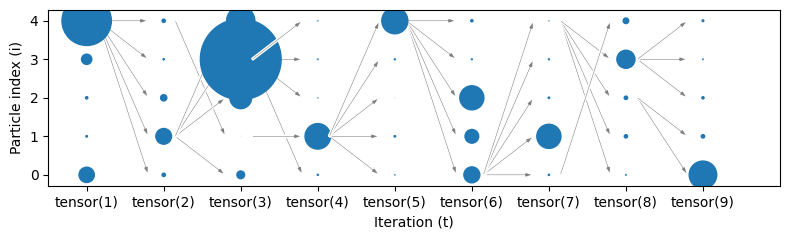

In [239]:
def plot_smc_weights(weights, indexes, n_steps, spacing=1.5, max_size=0.3):
    """
    Plot the evolution of weights in the sequential Monte Carlo (SMC) algorithm.

    Parameters
    ----------
    weights: array(n_particles, n_steps)
        Weights at each time step.
    n_steps: int
        Number of steps to plot.
    spacing: float
        Spacing between particles.
    max_size: float
        Maximum size of the particles.
    
    Returns
    -------
    fig: matplotlib.figure.Figure
        Figure containing the plot.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect(1)

    weights_subset = weights[:n_steps]
    # sampled indices represent the "position" of weights at the next time step
    ix_subset = indexes[:n_steps]

    for it, (weights_row, p_target) in enumerate(zip(weights_subset, ix_subset)):
        norm_cst = weights_row.sum()
        radii = weights_row / norm_cst * max_size
        for particle_ix, (rad, target_ix) in enumerate(zip(radii, p_target)):
            # print(rad, target_ix)
            if it != n_steps - 2:
                diff = particle_ix - target_ix
                plt.arrow(spacing * (it + 0.15), target_ix, 1.3, diff, width=0.05,
                        edgecolor="white", facecolor="tab:gray", length_includes_head=True)
            circle = plt.Circle((spacing * it, particle_ix), rad, color="tab:blue")
            ax.add_artist(circle)

    plt.xlim(-1, n_steps * spacing - 2)
    plt.xlabel("Iteration (t)")
    plt.ylabel("Particle index (i)")

    xticks_pos = torch.arange(0, n_steps * spacing - 2, 2)
    xticks_lab = torch.arange(1, n_steps)
    plt.xticks(xticks_pos, xticks_lab)

    # ylims = ax.axes.get_ylim() # to-do: grab this value for SCM-particle descendents' plot

    return fig, ax

fig, ax = plot_smc_weights(w_smc, s_idxs, n_steps=10, spacing=spacing)
ylims = ax.axes.get_ylim()
plt.tight_layout()

## Note (SIS, SISR, SISR with adaptive resampling logic analysis)

As you can see from the above plots, the weights are almost zero for all except one in case of SIS plot. Where as in case of SISR the weight decay happens but not to that extend which we see in SIS. I have not used log weights in the above example as the no. of steps is very small so they dont tend to infinity. Which if happens weights will become NANs. Which we dont want. This problem I have solved in the below question by treating the weights in log space and use logsumexp to avoid NANs.

## State space model

State space models are sequencial model whose value of current sequence depends on some latent variable sequence. This can se said as graphical models with chain structure. These have a form as below,
$$
p(y_{1:T},z_{1:T}|u_{1:T}) = [p(z_1|u_1)\prod_{t=2}^T p(z_t|z_{t-1},u_t)]\:[\prod_{t=1}^{T} p(y_t|z_t, u_t)] 
$$
Here, Inital state  is $p(z_1|u_1)$, $\prod_{t=2}^T p(z_t|z_{t-1},u_t)$ is the dynamic/transistion model, $\prod_{t=1}^{T} p(y_t|z_t, u_t)$ is the observation/measurement model.

For more details check reference books on it.

## Bootstrap filter (Survival of the fittest algorithm)

For SSMs the value of alpha becomes simple to calculate, because the proposal distribution becomes equal to the dynamical prior.
$$
q_t(z_t|z_{1:t-1}) = p(z_t|z_{1:t-1})
$$
So the incremental weight or alpha becomes
$$
\alpha_t(z_{1:t}) = \dfrac{p(y_t|z_{1:t})p(z_t|z_{1:t-1})}{q_t(z_t|z_{1:t-1})} = p(y_t|z_{1:t})
$$
### 2d non-linear tracking problem

Here is a sample application code used in SSMs, a 2d non-linear tracking problem with 
$$
p(z_t|z_{t-1}) = N(z_1|f(z_{t-1}),qI) \\
p(y_t|z_t) = N(y_t|z_t, rI) \\
$$

In [240]:
class SampleGeneratorSSM:

    def __init__(self, z_function: Callable, q=0.001, r=0.05):
        self.z_function = z_function
        self.q = q
        self.r = r

    def z_dist(self, zt: torch.Tensor):
        return torch.distributions.MultivariateNormal(loc=z_function(zt),
                                                      covariance_matrix=self.q * torch.eye(zt.shape[-1]))
    
    def y_dist(self, zt: torch.Tensor):
        return torch.distributions.MultivariateNormal(loc=zt,
                                                      covariance_matrix=self.r * torch.eye(zt.shape[-1]))

    def sample_y(self, zt_next):
        p_y = self.y_dist(zt_next)
        yt_next = p_y.sample()
        return yt_next

    def sample_z(self, zt):
        p_z = self.z_dist(zt)
        zt_next = p_z.sample()
        return zt_next
    
    def _step(self, zt = torch.tensor([1.5, 0.0])):
        zt_next = self.sample_z(zt)
        yt_next = self.sample_y(zt_next)
        return zt_next, torch.stack((zt_next, yt_next))
    
    def samples(self, z0, N_s = 100):
        def scan(func, init_values, length):
            carry = init_values
            logs_chain = []
            for i in range(length):
                carry, logs = func(carry)
                logs_chain.append(logs)
            logs_output = torch.stack(logs_chain,dim=1)
            return carry, logs_output
       
        _, logs_chain = scan(self._step, z0, N_s)
        # (zt,yt)
        return logs_chain
    
def z_function(z, delta=0.4):
    z_x = z[0] + delta * torch.sin(z[1])
    z_y = z[1] + delta * torch.cos(z[0])
    return torch.cat((torch.unsqueeze(z_x,0), torch.unsqueeze(z_y,0)))

## Sample Generator and Predictor
Here for sample Generation I have used this z-function
$$
f(z)_{sampler} = (z_1 + \Delta sin(z_2), z_2+\Delta cos(z_1))
$$
Whereas for sample prediction I have used this z-function
$$
f(z)_{predictor} = (z_1 + \Delta z_2, z_2+\Delta z_1)
$$


In [241]:
def z_function_sampler(z, delta=0.4):
    z_x = z[0] + delta * torch.sin(z[1])
    z_y = z[1] + delta * torch.cos(z[0])
    return torch.cat((torch.unsqueeze(z_x,0), torch.unsqueeze(z_y,0)))

def z_function_predictor(z, delta=0.8):
    z_x = z[0] + delta * z[1]
    z_y = z[1] + delta * z[0]
    return torch.cat((torch.unsqueeze(z_x,0), torch.unsqueeze(z_y,0)))

T = 100
N_s = 5
# Samples generation for N_s particles
samples_list = []
samples_actual_z_list = []
generator_model = SampleGeneratorSSM(z_function_sampler)
for _ in range(N_s):
    z0 = torch.tensor([1.5, 0.0])
    samples = generator_model.samples(z0, T)
    samples_list.append(samples[1])
    samples_actual_z_list.append(samples[0])

ns_samples = torch.stack(samples_list)
ns_zt_actual_samples = torch.stack(samples_actual_z_list)
# ns_samples = ns_samples.transpose(0,1)
print(ns_samples.shape)
# print(ns_zt_actual_samples.shape)

torch.Size([5, 100, 2])


## Random SSM Sampler 
Here I have used the code used above for SISR with modifications based on z

In [258]:
class RandomSSMSampler:

    def __init__(self, z_function: Callable, N_s=10, q=0.001, r=0.05):
        self.z_function = z_function
        self.q = q
        self.r = r
        self.N_s = N_s

    def z_dist(self, zt: torch.Tensor):
        return torch.distributions.MultivariateNormal(loc=z_function(zt),
                                                      covariance_matrix=self.q * torch.eye(zt.shape[-1]), validate_args=False)
    
    def y_dist(self, zt: torch.Tensor):
        return torch.distributions.MultivariateNormal(loc=zt,
                                                      covariance_matrix=self.r * torch.eye(zt.shape[-1]), validate_args=False)
    
    def z_step(self, zt: torch.Tensor):
        return torch.stack([self.z_dist(z).sample() for z in zt])
    
    def alpha_step(self, zt: torch.Tensor, yt: torch.Tensor):
        def alpha_per_sample(zt_per_sample: torch.Tensor, yt_per_sample: torch.Tensor):
            return self.y_dist(zt_per_sample).log_prob(yt_per_sample)
        return torch.vmap(alpha_per_sample)(zt, yt)

    def inits(self, sample_shape):
        mu_0 = torch.zeros(sample_shape)
        z_i_0 = torch.tensor([1.5, 0.0]).repeat((5,1))
        w_i_0 = torch.zeros(sample_shape[0])
        return mu_0, z_i_0, w_i_0

    def resample_permute(self, w_i_t, z_i_t):
        def resample():
            indexs = [torch.distributions.Categorical(logits=w_i_t).sample((self.N_s,))]
            return indexs, torch.cat([z_i_t[index] for index in indexs])
        indexs, z_i_t = resample()
        w_i_t = torch.log(torch.tensor(1/self.N_s)) * torch.ones((self.N_s))
        return indexs, z_i_t, w_i_t
    
    def sisr_with_adaptive_resampling(self, y_ts, T, min_weight):
        z_1 = torch.tensor([1.5, 0.0])
        z_i_t = self.z_step(z_1.repeat((self.N_s,1)))
        w_i_t = torch.stack([self.y_dist(zt).log_prob(yt) for zt,yt in zip(z_i_t, y_ts[0])])
        W_i_t = torch.exp(w_i_t - torch.logsumexp(w_i_t, dim=0))
        mc_post_t = torch.matmul(W_i_t,torch.abs(z_1-z_i_t))
        normalized_w, Z_ts, posteriors, selected_indexs, particle_zs = [], [], [], [], []
        prev_w_i_t = torch.ones(self.N_s)
        Z_t = torch.tensor([1,1])
        normalized_w.append(W_i_t)
        posteriors.append(mc_post_t)
        particle_zs.append(z_i_t)

        for t in range(1, T):
            z_i_t = self.z_step(z_i_t)
            alpha = torch.stack([self.y_dist(zt).log_prob(yt) for zt,yt in zip(z_i_t, y_ts[0])])
            w_i_t = w_i_t + alpha
            if self.ESS(w_i_t, ess_min=min_weight):
                indexes, z_i_t, w_i_t = self.resample_permute(w_i_t, z_i_t)
                selected_indexs.append((t, indexes))
                # print('resample')
            W_i_t = torch.exp(w_i_t - torch.logsumexp(w_i_t, dim=0))
            mc_post_t = torch.matmul(W_i_t,torch.abs(z_1-z_i_t))
            normalized_w.append(W_i_t)
            posteriors.append(mc_post_t)
            # normalization const
            Z_t = self.calc_Z(w_i_t, prev_w_i_t, Z_t)
            Z_ts.append(Z_t)
            prev_w_i_t = w_i_t
            particle_zs.append(z_i_t)
            # print(W_i_t, w_i_t)

        states = self.extract_states(torch.stack(normalized_w), torch.stack(particle_zs))
        return torch.stack(posteriors), states, torch.stack(Z_ts), selected_indexs
    
    def extract_states(self, normalized_w, particle_zs):
        states = []
        for t in range(normalized_w.shape[0]):
            index = torch.distributions.Categorical(probs=normalized_w[t]).sample()
            states.append(particle_zs[t][index])
        return torch.stack(states)

    def ESS(self, w_i_t, ess_min):
        ess = w_i_t.sum().square() / w_i_t.square().sum()
        if ess < ess_min:
            return True
        else:
            return False
        
    def calc_Z(self, w_i_t, prev_w_i_t, prev_Z_t):
        # Z_t/Z_{t-1}
        Z_t_Z_t_1 = torch.sum(w_i_t,dim=0) / torch.sum(prev_w_i_t,dim=0)
        # Z_t
        return prev_Z_t * Z_t_Z_t_1
    
    def _step(self, zt = torch.tensor([1.5, 0.0])):
        zt_next = self.z_dist(zt).sample()
        yt_next = self.y_dist(zt_next).sample()
        return zt_next, torch.stack((zt_next, yt_next))
    
    def samples(self, z0, T = 100):
        def scan(func, init_values, length):
            carry = init_values
            logs_chain = []
            for i in range(length):
                carry, logs = func(carry)
                logs_chain.append(logs)
            logs_output = torch.stack(logs_chain,dim=1)
            return carry, logs_output
       
        _, logs_chain = scan(self._step, z0, T)
        # (zt,yt)
        return logs_chain
    
def z_function_sampler(z, delta=0.4):
    z_x = z[0] + delta * torch.sin(z[1])
    z_y = z[1] + delta * torch.cos(z[0])
    return torch.cat((torch.unsqueeze(z_x,0), torch.unsqueeze(z_y,0)))

def z_function_predictor(z, delta=0.8):
    z_x = z[0] + delta * z[1]
    z_y = z[1] + delta * z[0]
    return torch.cat((torch.unsqueeze(z_x,0), torch.unsqueeze(z_y,0)))

particles = 5
model = RandomSSMSampler(z_function_predictor, N_s=particles)
# model.sisr_with_adaptive_resampling(ns_samples.transpose(0,1), T, min_weight=particles/5)
predicted_posteriors, predicted_zs, predicted_Zts, resample_indexes = model.sisr_with_adaptive_resampling(ns_samples.transpose(0,1), T, min_weight=particles*0.78)
# print(predicted_zs.shape)

## After Learning

Here I have created few samples after learning is complete. This helps us check if the path followed is moving in correct direction. 

In [259]:
after_learning = model.samples(predicted_zs[-1], 10)
print(after_learning[1].shape)

torch.Size([10, 2])


<Axes: title={'center': 'custom linear gaussian state space model'}>

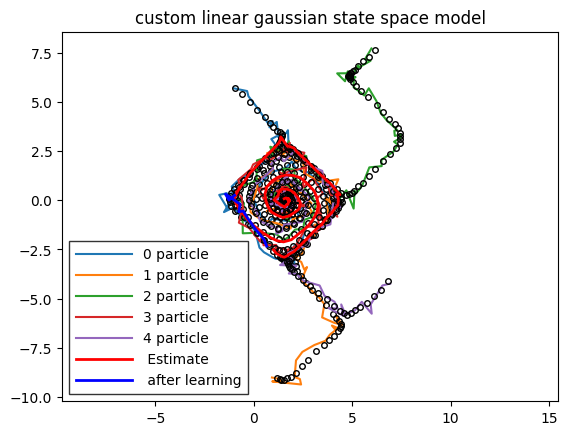

In [260]:
def plot_inference(N_s, states, emissions, estimates=None, after_learning_eastimates=None, est_type="", ax=None, title="", aspect=0.8, show_states=True):
    lines = []
    # print(estimates.shape, after_learning_eastimates.shape)
    for i in range(N_s):
        s, e = states[i], emissions[i]
        if ax is None:
            fig, ax = plt.subplots()
        if show_states:
            line, = ax.plot(*s.T, label=f'{i} particle')
            lines.append(line)
        ax.plot(*e.T, "ok", fillstyle="none", ms=4, label="Observations")

    if estimates is not None:
        line, = ax.plot(*estimates.T, color="r", linewidth=2, label=f"{est_type} Estimate")
        lines.append(line)
    if after_learning_eastimates is not None:
        line, = ax.plot(*after_learning_eastimates.T, color="b", linewidth=2, label=f"{est_type} after learning")
        lines.append(line)
    ax.legend(borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k", handles=lines)
    #ax.set_aspect(aspect)
    ax.set_title(title)
    ax.axis('equal')
    return ax

plot_inference(N_s, ns_samples, ns_zt_actual_samples, predicted_zs, after_learning[1], title='custom linear gaussian state space model', show_states=True)

# Analysis

Here you can see from the plot that I have used 5 particles to generate samples and pass it to the SISR sampler which trains the latent variable to generate samples equivalent to the generator. This is shown by Estimate. After learning is complete, I create samples from the learning z. These samples follow the path and dont deviate from the training.

# References

Here the plots used is modified from 

https://github.com/probml/pyprobml

https://github.com/probml/JSL/tree/main

However I have written the code on my own as per my understanding of the models.

I have studied Probablistic Machine Learning By Kevin P. Murphy and written everything as per my understanding.